### Regression task 1

Bayesian Logistic Regression to predict the probability of a home team winning a game based on the odds. It assumes prior uncertainty about the model's coefficients (intercept and slope) and updates these beliefs using data. MCMC sampling is used to estimate the posterior distributions of the coefficients, giving us a range of possible values rather than fixed ones. This approach helps quantify uncertainty.

# Bayesian Logistic Regression Model Description

This model is a **Bayesian Logistic Regression**, where the goal is to predict the probability of a binary outcome (home win) based on the odds of the home team winning.

- **Priors:**
  - The intercept (β₀) follows a normal distribution with a mean of 0 and a standard deviation of 5.
  - The slope (β₁) follows a normal distribution with a mean of 0 and a standard deviation of 1.

- **Logistic Regression Model:**
  The log-odds (logit) of the outcome is modeled as a linear function of the home team odds:
  $$ logit(p) = β₀ + β₁ × odds\_home$$

  where \( p \) is the probability of a home win.

- **Likelihood:**
  The observed data is modeled using a Bernoulli distribution with the probability \( p \) derived from the logistic function.

- **Sampling:**
  Posterior distributions of the parameters (β₀ and β₁) are estimated using Markov Chain Monte Carlo (MCMC) sampling.

- **Inference:**
  The posterior distributions of the parameters are visualized, and predictions are made for the probability of a home win across a range of odds. Uncertainty is captured by plotting the 95% Highest Density Interval (HDI) for the parameters.

In [ ]:
import pandas as pd
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('cleaned_football_data.csv')

# Split data by league and season
serie_a_data = data[data['League'] == 'Serie A']
pl_data = data[data['League'] == 'Premier League']

display(serie_a_data.head())
display(pl_data.head())

In [80]:
columns_with_nan = data.columns[data.isna().sum() > 0]
columns_with_nan

Index([], dtype='object')

In [81]:
home_odds_columns = ['B365H', 'BWH', 'IWH', 'PSH', 'VCH', 'WHH']
odds_home = data[home_odds_columns].values
home_win = data['HomeWin'].values

In [102]:
# Bayesian Logistic Regression Model
with pm.Model() as model:
    # Priors for intercept and coefficients, informed by expected probabilities
    beta_0 = pm.Normal('beta_0', mu=0, sigma=2) # Log-odds centered around 0 (p=0.5)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=len(home_odds_columns))  # Coefficients with moderate variability

    # Logistic regression model (log-odds to probability)
    logit_p = beta_0 + pm.math.dot(odds_home, beta)  # Linear combination
    p = pm.Deterministic('p', pm.math.sigmoid(logit_p))  # Logistic function for probability

    # Likelihood: Observed outcomes are binary (home win: 1, loss/draw: 0)
    observed = data['HomeWin']  # Binary outcomes (1 for home win, 0 otherwise)
    y = pm.Bernoulli('y', p=p, observed=observed)

    # Sampling the posterior
    trace = pm.sample(1000, return_inferencedata=True)


Output()

Output()

ERROR:pymc.stats.convergence:There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [119]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.558,0.271,-0.044,0.815,0.137,0.106,5.0,131.0,2.23
beta[1],-0.284,0.766,-1.326,0.463,0.529,0.444,3.0,76.0,2.24
beta[2],0.327,0.432,-0.204,0.755,0.302,0.257,3.0,190.0,2.23
beta[3],-0.123,0.332,-0.631,0.183,0.219,0.180,3.0,73.0,2.23
beta[4],0.543,0.269,-0.057,0.742,0.145,0.123,4.0,102.0,2.24
...,...,...,...,...,...,...,...,...,...
p[6075],0.780,0.203,0.566,0.983,0.143,0.121,3.0,65.0,2.23
p[6076],0.795,0.174,0.610,0.969,0.122,0.104,3.0,83.0,2.23
p[6077],0.599,0.401,0.182,1.000,0.282,0.239,3.0,69.0,2.23
p[6078],0.788,0.184,0.593,0.972,0.129,0.109,3.0,76.0,2.23


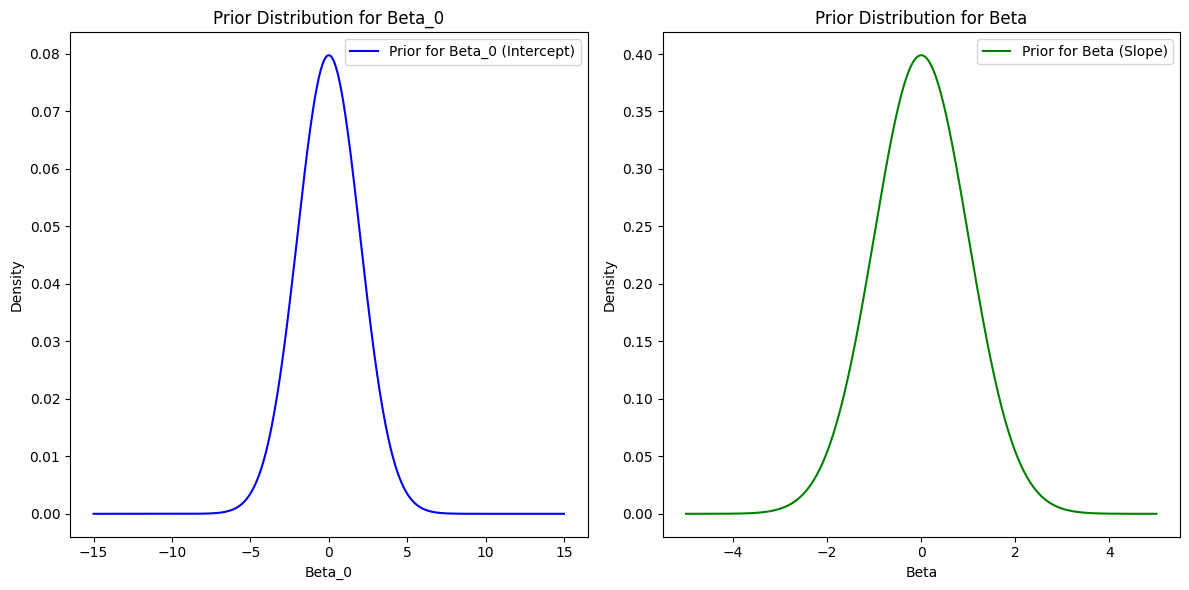

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Plot priors
x_beta_0 = np.linspace(-15, 15, 500)  # Range for intercept
x_beta_1 = np.linspace(-5, 5, 500)   # Range for slope

# Prior distributions
prior_beta_0 = np.exp(-0.5 * (x_beta_0 / 2)**2) / (5 * np.sqrt(2 * np.pi))  # N(0, 5)
prior_beta_1 = np.exp(-0.5 * (x_beta_1 / 1)**2) / (1 * np.sqrt(2 * np.pi))  # N(0, 1)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_beta_0, prior_beta_0, label='Prior for Beta_0 (Intercept)', color='blue')
plt.title('Prior Distribution for Beta_0')
plt.xlabel('Beta_0')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_beta_1, prior_beta_1, label='Prior for Beta (Slope)', color='green')
plt.title('Prior Distribution for Beta')
plt.xlabel('Beta')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


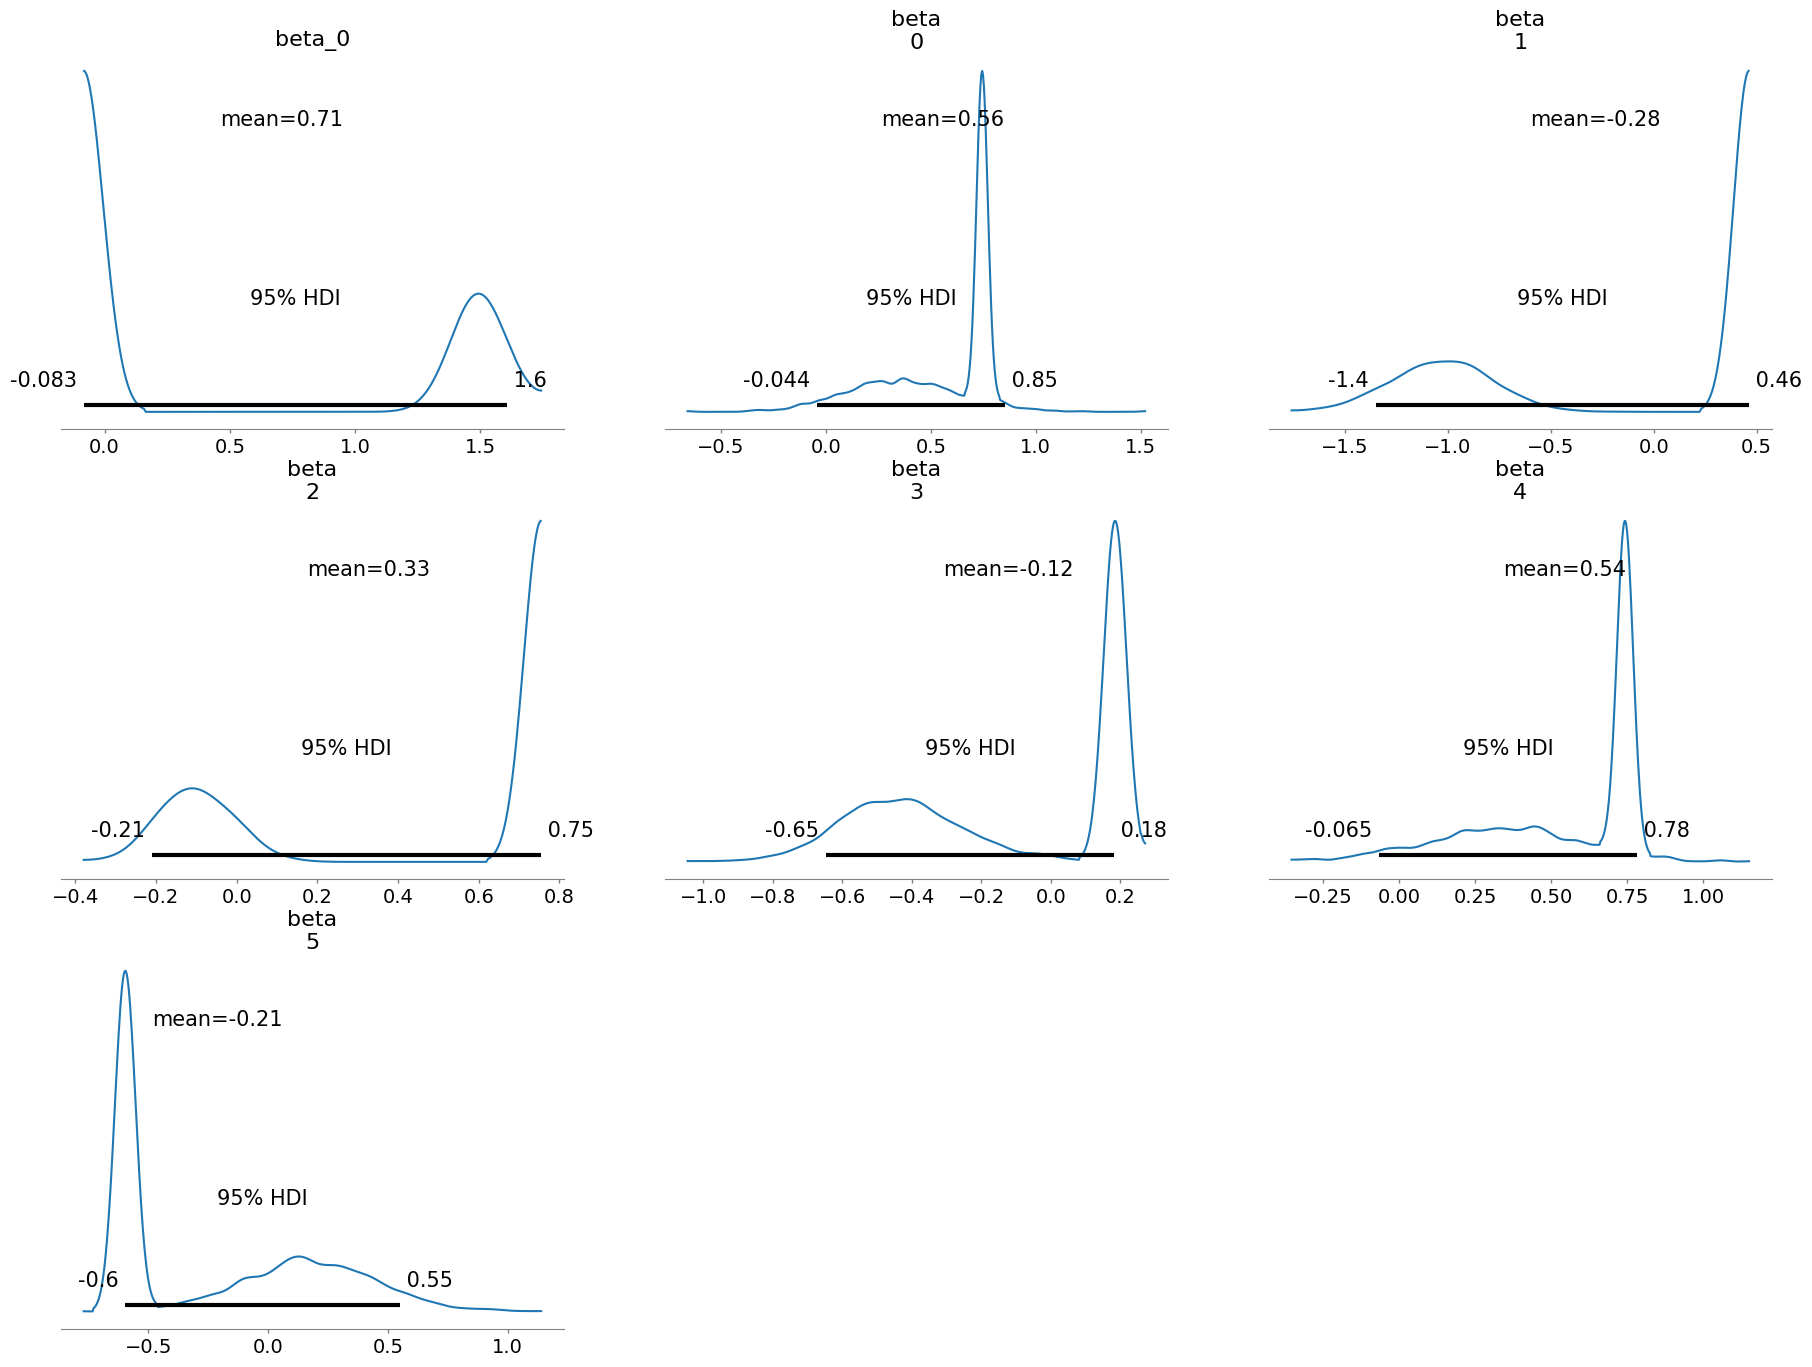

In [105]:
# 3.2: Plot posterior distributions
pm.plot_posterior(trace, var_names=['beta_0', 'beta'], hdi_prob=0.95)
plt.show()

<ipython-input-122-999416a4715c>:2: FutureWarning: extract_dataset has been deprecated, please use extract
  idata = az.extract_dataset(trace)


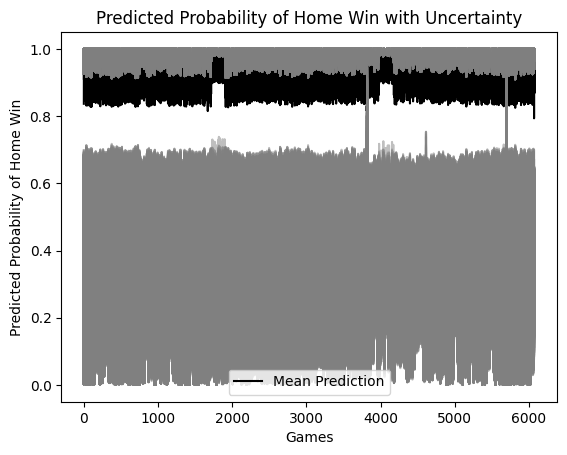

In [122]:
import arviz as az
idata = az.extract_dataset(trace)

# Get posterior samples for beta_0 and beta
beta_0_samples = idata.beta_0.values.flatten()
beta_samples = idata.beta.values.T  # Transpose so each column corresponds to a different coefficient

# Calculate the mean predicted probabilities (logistic regression model)
beta_0_hat = beta_0_samples.mean()
beta_hat = beta_samples.mean(axis=0)

# Compute the mean prediction using the posterior mean of the coefficients
logit_mean = beta_0_hat + np.dot(odds_home, beta_hat)
prob_mean = 1 / (1 + np.exp(-logit_mean))  # Logistic function for probability

# Plot the mean prediction curve (based on the posterior mean)
plt.plot(np.arange(len(home_win)), prob_mean, c='k', label='Mean Prediction')

# Plot the uncertainty using posterior samples for different regression lines
chosen_samples = range(0, len(beta_0_samples), 10)

# Plot lines for each posterior sample
for i in chosen_samples:
    logit = beta_0_samples[i] + np.dot(odds_home, beta_samples[i, :])
    prob = 1 / (1 + np.exp(-logit))  # Logistic function for probability
    plt.plot(np.arange(len(home_win)), prob, c='gray', alpha=0.5)

plt.xlabel('Games')
plt.ylabel('Predicted Probability of Home Win')
plt.title('Predicted Probability of Home Win with Uncertainty')
plt.legend()
plt.show()

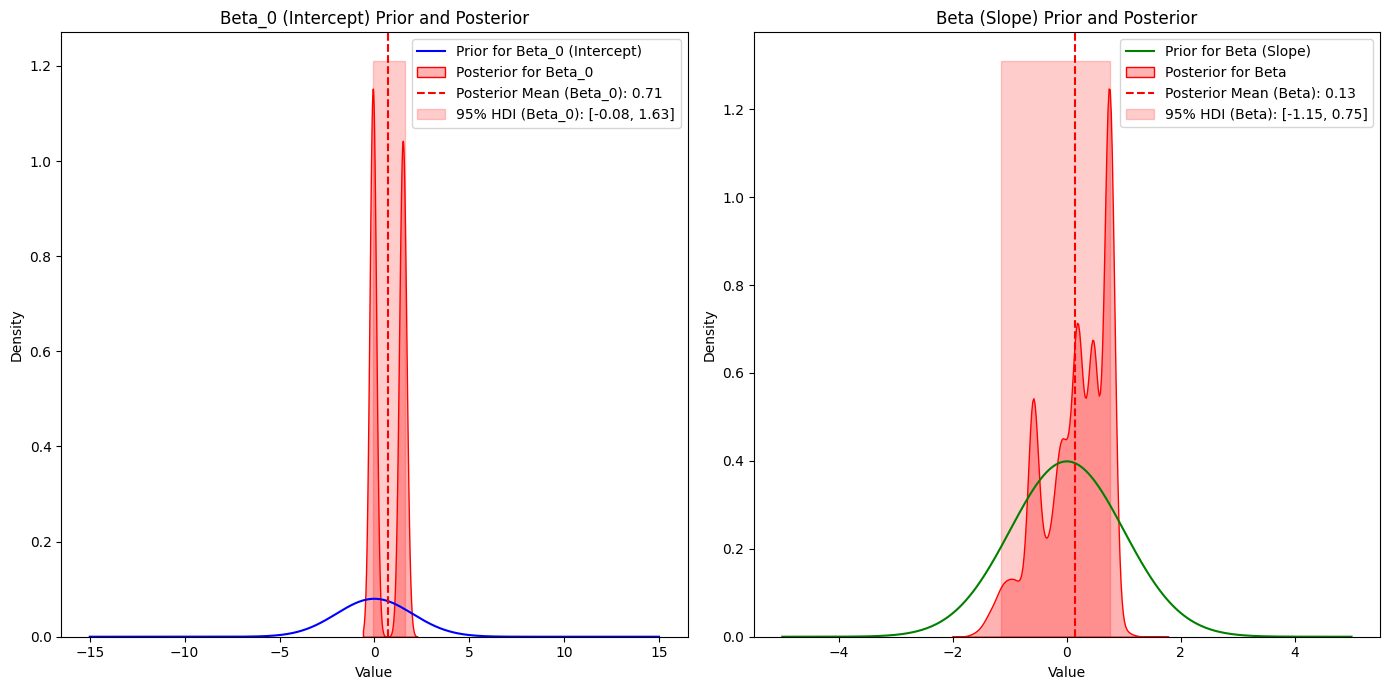

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

# Extract posterior samples from the trace
beta_0_samples = trace.posterior['beta_0'].values.flatten()
beta_1_samples = trace.posterior['beta'].values.flatten()

# Define ranges for prior PDFs
x_beta_0 = np.linspace(-15, 15, 500)
x_beta_1 = np.linspace(-5, 5, 500)

# Prior distributions
prior_beta_0 = np.exp(-0.5 * (x_beta_0 / 2)**2) / (5 * np.sqrt(2 * np.pi))  # N(0, 1/10)
prior_beta_1 = np.exp(-0.5 * (x_beta_1 / 1)**2) / (1 * np.sqrt(2 * np.pi))  # N(0, 1)

# Plot Priors and Posteriors for Beta_0 and Beta_1
plt.figure(figsize=(14, 7))

# Beta_0 (Intercept)
plt.subplot(1, 2, 1)
plt.plot(x_beta_0, prior_beta_0, label="Prior for Beta_0 (Intercept)", color="blue")
sns.kdeplot(beta_0_samples, label="Posterior for Beta_0", color="red", fill=True, alpha=0.3)
plt.title("Beta_0 (Intercept) Prior and Posterior")
plt.xlabel("Value")
plt.ylabel("Density")

# Annotate Prior and Posterior values (mean and credible interval)
mean_beta_0 = np.mean(beta_0_samples)
hdi_beta_0 = np.percentile(beta_0_samples, [2.5, 97.5])
plt.axvline(mean_beta_0, color="red", linestyle="--", label=f"Posterior Mean (Beta_0): {mean_beta_0:.2f}")
plt.fill_betweenx(
    [0, plt.gca().get_ylim()[1]], hdi_beta_0[0], hdi_beta_0[1], color="red", alpha=0.2,
    label=f"95% HDI (Beta_0): [{hdi_beta_0[0]:.2f}, {hdi_beta_0[1]:.2f}]"
)
plt.legend()

# Beta_1 (Slope)
plt.subplot(1, 2, 2)
plt.plot(x_beta_1, prior_beta_1, label="Prior for Beta (Slope)", color="green")
sns.kdeplot(beta_1_samples, label="Posterior for Beta", color="red", fill=True, alpha=0.3)
plt.title("Beta (Slope) Prior and Posterior")
plt.xlabel("Value")
plt.ylabel("Density")

# Annotate Prior and Posterior values (mean and credible interval)
mean_beta_1 = np.mean(beta_1_samples)
hdi_beta_1 = np.percentile(beta_1_samples, [2.5, 97.5])
plt.axvline(mean_beta_1, color="red", linestyle="--", label=f"Posterior Mean (Beta): {mean_beta_1:.2f}")
plt.fill_betweenx(
    [0, plt.gca().get_ylim()[1]], hdi_beta_1[0], hdi_beta_1[1], color="red", alpha=0.2,
    label=f"95% HDI (Beta): [{hdi_beta_1[0]:.2f}, {hdi_beta_1[1]:.2f}]"
)
plt.legend()

plt.tight_layout()
plt.show()
